# Project 2: Web Traffic Analysis
**This is the second of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-11-10, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
In this project your task is to analyze a stream of log entries. A log entry consists of an [IP address](https://en.wikipedia.org/wiki/IP_address) and a [domain name](https://en.wikipedia.org/wiki/Domain_name). For example, a log line may look as follows:

`192.168.0.1 somedomain.dk`

One log line is the result of the event that the domain name was visited by someone having the corresponding IP address. Your task is to analyze the traffic on a number of domains. Counting the number of unique IPs seen on a domain doesn't correspond to the exact number of unique visitors, but it is a good estimate.

Specifically, you should answer the following questions from the stream of log entries.

- How many unique IPs are there in the stream?
- How many unique IPs are there for each domain?
- How many times was IP X seen on domain Y? (for some X and Y provided at run time)

**The answers to these questions can be approximate!**

You should also try to answer one or more of the following, more advanced, questions. The answers to these should also be approximate.

- How many unique IPs are there for the domains $d_1, d_2, \ldots$?
- How many times was IP X seen on domains $d_1, d_2, \ldots$?
- What are the X most frequent IPs in the stream?

You should use algorithms and data structures that you've learned about in the lectures, and you should provide your own implementations of these.

Furthermore, you are expected to:

- Document the accuracy of your answers when using algorithms that give approximate answers
- Argue why you are using certain parameters for your data structures

This notebook is in three parts. In the first part you are given an example of how to read from the stream (which for the purpose of this project is a remote file). In the second part you should implement the algorithms and data structures that you intend to use, and in the last part you should use these for analyzing the stream.

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You may modify this if you want to, but your solution should remain parametrized, so that your notebook can be run without having to consume the entire file.

# Reading the stream

In [1]:
def stream(n):
    i = 0
    with urllib.request.urlopen('https://files.dtu.dk/fss/public/link/public/stream/read/traffic_2?linkToken=_DcyO-U3MjjuNzI-&itemName=traffic_2') as f:
        for line in f:
            element = line.rstrip().decode("utf-8")
            yield element
            i += 1
            if i == n:
                break

In [2]:
STREAM_SIZE = 100000
web_traffic_stream = stream(STREAM_SIZE)

# Libraries

In [3]:
import numpy as np
import urllib
import matplotlib.pyplot as plt
import math
import mmh3

# Data structures

For this assignment we implement to classes of skecthes. The first is the HyperLogLog sketch, that is used to estimate the number of unique elements in a stream. The second is the CountMin Sketch, that (over)counts the frequency by which each elements occurs in the stream. To solve the problems, both type of sketches are used in different ways and with slight adjustments, that will be described along the solutions.

## HyperLogLog class
Below the HyperLogLog algorithm is implemented based on the paper (1). It is used to create an efficient data structure for computing the number of distinct elements in a stream. The class consists of a range of functions, the init function will initialize specified parameters and the M registers. The $\texttt{getAlpha()}$ function will act as a correcting constant for the harmonic mean based on the chosen parameter $b$ defining the size of the $M$ registers. We then construct the $M$ registers by using a hash function turning the IPs into binary bits. The idea is, that the more leading zeros a binary part contains, the more unlikely it is to observe. Hence, it would statistically require more unique elements in the stream before observing this. <br> Finally when $M$ has been constructed, the raw estimate of the estimated distinct count can be found. To correct for large and small values, a corrector function is also included. To find accuracies a function for the confidence interval can also be called.

<br>
(1) Philippe Flajolet, Eric Fusy, Olivier Gandouet, Frédéric Meunier. HyperLogLog: the analysis of a near-optimal cardinality estimation algorithm. Analysis of Algorithms 2007 (AofA07), Jun 2007, Juan les pins, France. pp.127–146. ffhal-00406166v1f


In [4]:
"""
A framework for using the HyperLogLog algorithm to approximate the number of distinct elements in a multiset.
Args:
    b: Integer, indicates the number of substreams to use for the matrix M.
    IP, domains: Strings, Stream inputs
    M2, M: m x m, Matrix registers to store substreams for averaging harmonic mean
    level: integer, sets the level of the confidence
"""
class HyperLogLog:
    def __init__(self, b = 10):
        try:
            assert 4 <= b & b <= 16
        except:
            print("b needs to be an integer in [4,16]")
        self.b = b
        self.m = 2**self.b
        self.M = np.zeros(self.m)
        self.alpha = self.getAlpha()
    
    #Update alpha value based on m to give correct raw estimate of the harmonic mean
    def getAlpha(self):
        if self.m== 16:
            self.alpha = 0.673
        elif self.m==32:
            self.alpha=0.697
        elif self.m == 64:
            self.alpha=0.709
        else:
            self.alpha =0.7213/(1+1.079/self.m)
        return self.alpha
    
    #Update the matrix M for each substream.
    def updateCounter(self,IP, seed=42):
        
        # 32-bit Hash, convert to binary
        x = bin(mmh3.hash(IP, signed=False, seed=seed))
        
        # Remove inappropiate formatting and paddin 0s to achieve correct length
        x = x[2:].zfill(int(math.log(2**32,2)))
        
        # We do not +1, since python is 0 index
        j = int(x[0:self.b],2)
        w = x[self.b:]
        
        # Increment by 1 so we avoid -1
        p_w = w.find('1') + 1
        self.M[j] = max(self.M[j],p_w)
        return self.M
    
    #Calculate the raw harmonic mean E.
    def getRawEstimator(self):
        Z = 1/np.sum(2**(-1*self.M))
        E = self.alpha * self.m**2 * Z
        return E
    
    # Corrector function to adjust the harmonic mean 
    # based on the size of the estimated count
    def count(self):
        # Small range correction
        E=self.getRawEstimator()
        if E <= 5/2 * self.m:
            V = np.sum(self.M == 0)
            
            # If some buckets are still empty
            if V != 0:
                #Linear Counting
                E_opt = self.m*math.log(self.m/V)
        
        # No correction
        elif E <= 1/30*2**32:
            E_opt = E
        
        # Large range correction
        else:
            E_opt = -2**32*math.log(1-E/2**32)
        return E_opt
    
    # If more domains given, then find the union of M for each specified 
    # domain to avoid IP duplicates in domains.
    def unionCount(self, domains, M2):
        M=np.zeros(self.m)
        for d in range(len(domains)):
            for i in range(self.m):
                M[i]=max(M[i], M2[domains[d]][i])
        self.M=M
        unionCount=self.count()
        return unionCount
    
    # Find confidence interval of the HyperLogLog count estimate.
    def confint(self, level):
        sigma=1.04*1/np.sqrt(HLL.m)
        #define confidence interval level
        if level == 65:
            sigma=sigma
        elif level == 95:
            sigma=2*sigma
        elif level == 99:
            sigma=3*sigma
               
        # Compjute upper and lower conf bound
        est = int(np.round(HLL.count()))
        lwr = int(np.floor(HLL.count() - HLL.count()*sigma))
        upr = int(np.ceil(HLL.count() + HLL.count()*sigma))
        return lwr, est, upr, "Std of estimation: "+str(round(HLL.count()*sigma,1))

### HyperLogLog register across all domains

Here the register matrix M is updated for each substream, so it can be used to find the harmonic mean $E$.

In [5]:
web_traffic_stream = stream(STREAM_SIZE)

HLL = HyperLogLog(b=9)

# Construct the data structure
for i in web_traffic_stream:
    IP,domain = i.split("\t")
    # Update M for each substream, IP.
    MIPall = HLL.updateCounter(IP)

### HyperLogLog register for each domain

In [6]:
web_traffic_stream = stream(STREAM_SIZE)

HLL = HyperLogLog(b=9)
MforEachUniqueDomain = {}

for i in web_traffic_stream:
    IP,domain = i.split("\t")
    
    # If domain doesn't exist, create new M in dict
    if domain not in MforEachUniqueDomain:
        MforEachUniqueDomain[domain]=np.zeros(HLL.m)
        
    # We get a unique M for each domain, so we set M in HLL class
    HLL.M=MforEachUniqueDomain[domain]
    
    # Update counters for relevant domain
    MforEachUniqueDomain[domain] = HLL.updateCounter(IP)

## CountMin Sketch class
Below the CountMin Sketch algorithm is implemented as a class based on the description provided at lectures. It is used to construct a sketch for estimating the frequency of the distinct elements in a stream without storing these. The class consists of a range of functions, the init function will initialize specified parameters and a $d \times w$ matrix, $M$ with zeros. When an element arrives, the IP string is hashed using $d$ different hash functions from the same family, all hasing to an interger between $0$ and $w$. The $M_{i,h_i(\text{IP})}, d \in \{1,...,d\}$ is incremented where $h_i(\text{IP})$ is the hashed value of the IP using hash function $i$. After running through the entire stream, the estimated frequency of an element $e$ will be the minimum value of $M_{i,h_i(e)}, d \in \{1,...,d\}$. The motivation for making $d$ estimates and choosing the smallest is to avoid getting corrupted results due to collisions. There is $1/w$ chance that two different IPs will map to the same value resulting in a wrong final estimate. However, there is only $1/(w^d)$ that two elements collide in every of the $d$ hash functions. This requires $w \cdot d$ registers. This is, the probability of not being able to distinct to elements in the sketch can be dramatically decreased by only requiring $d$ times a much memory usage. If we was to achieve the same decrease in probability by simply increasing $w$ and not making multiple array, we should increase to $w^d$ which would require $m^d \gg m \cdot d$ registers. A huge save in memory usage.

<br>

In [7]:
"""
A framework for creating a ContMinSketch to approximate the frequency of elements in a stream.
Args:
    epsilon: Float, how many factors the estimate i allowed to be from the true value
    delta: Float, between 0 and 1. 1-delta is the probability that the true value is with epsilon factors from the estimate.
    IP, domains: Strings, Stream inputs
"""
class CountMinSketch:
    def __init__(self, epsilon = 0.0001, delta = 0.001):
        self.w = int(np.ceil(np.exp(1)/epsilon))
        self.d = int(np.ceil(np.log(1/delta)))
        try:
            assert (0 < delta) and (1 > delta)
            assert (self.w < 2**32)
        except:
            print("delta needs to be between 1 and 0, epsilon more than 6.328993078*10^(-10)")
        self.M = np.zeros((self.d,self.w)) # The CountMinSketch
        self.frequentItem = dict()
    
    def updateCountMinSketch(self,IP,seed=42): #string,M,b
        
        # Find the d coloumns that the IP hashes to
        hashCols = [mmh3.hash(IP, seed = i) % self.w for i in range(self.d)]
        
        # Increment the counters
        self.M[range(self.d),hashCols] += 1
        
        return(self.M)
            

    def count(self,IP,seed=42):
        
        # Find the d coloumns that the IP hashes to
        hashCols = [mmh3.hash(IP, seed = i) % self.w for i in range(self.d)]
        
        # Fin the minimal value of the counters
        counts = self.M[range(self.d),hashCols]
        return min(counts)
        
    def countMostFrequentOnTheFly(self,IP):
        seenUntilNow = self.count(IP)
        
        # Only save if more than two apperances otherwise trivial
        if seenUntilNow >= 2:
            self.frequentItem[IP] = seenUntilNow
            
        return(self.frequentItem)

### Construct the count min sketch across all domains and track most frequent IPs

In [8]:
web_traffic_stream = stream(STREAM_SIZE)

epsilon = 0.00001
delta = 0.001

CMS = CountMinSketch(epsilon = epsilon, delta = delta)

# Create dictionary that the current count of an elements (if it has been seen twice or more)
mostFrequentElements = dict()

for i in web_traffic_stream:
    IP,domain = i.split("\t")
    
    # Update counters for relevant domain
    countMinSketch = CMS.updateCountMinSketch(IP)
    
    # Construct most frequent dictionary
    mostFrequentDict = CMS.countMostFrequentOnTheFly(IP)

### Construct the count min sketch for each domain

Assuming the number of unqiue domains is low, it is possible to consturct a CountMin sketch for each domain without memory problems.

In [9]:
web_traffic_stream = stream(STREAM_SIZE)

epsilon = 0.00001
delta = 0.001

CMS = CountMinSketch(epsilon = epsilon, delta = delta)

# Dictionary with a CountMinSketch for each domain
countMinDictionary = dict()

# dictionary with the total number of elements for each domain
numerOfElementsWithDomain = dict()

for i in web_traffic_stream:
    IP,domain = i.split("\t")
    
    # Check if domain has been seen before
    if domain not in countMinDictionary:
        countMinDictionary[domain] = np.zeros((CMS.d,CMS.w))
        numerOfElementsWithDomain[domain] = 0
        
     # We get a unique M for each domain, so we set M in HLL class
    CMS.M = countMinDictionary[domain]
    
    # Update counters for relevant domain
    countMinDictionary[domain] = CMS.updateCountMinSketch(IP)
    numerOfElementsWithDomain[domain] += 1

# Analysis

The accuracy analysis and parameter choices for HyperLogLog and CountMinSketch has been executed using the two articles linked below. <br> CountMinSkecth: http://dimacs.rutgers.edu/~graham/pubs/papers/cm-full.pdf <br>
HyperLogLog: http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf

### 1) How many unique IPs are there in the stream?
The register was found in the section "HyperLogLog register across all domains". Using the data structure of $\texttt{MIPall}$ it is easy to find the estimate of count for unique IPs using the $\texttt{HLL.count()}$ function of the HyperLogLog class, calculating the harmonic mean.

In [10]:
# Count the number of unique IPs based on MIPall
HLL.M = MIPall
round(HLL.count())

93056.0

Using the standard error $\sigma = E\frac{\beta_m}{\sqrt{m}}$, where $b_m \sim 1.04$, we can find a likely confidence interval for the number of unique IPs in the stream, this is shown below, also included is the standard deviation:

In [11]:
HLL.confint(95)

(84502, 93056, 101611, 'Std of estimation: 8554.1')

Our best estimate of the number of unique IPs is 93056 while the true value with probability $95\%$ is within the interval $[84502;101611]$.

### 2) How many unique IPs are there for each domain?

The M register is found for each domain. The same parameter $b=9$ is used for them all.

In [12]:
E_Domain={}
Sd_Domain={}

# Query for each domain
for domain, M in MforEachUniqueDomain.items():
    # Update registers for each domain
    HLL.M=M
    # Find estimate for each domain using the HLL class
    E_Domain[domain]=int(round(HLL.count()))
    # Standard deviation for each domain
    Sd_Domain[domain]=round(HLL.count()/np.sqrt(HLL.m),3)

An estimate of the count of unique IPs for each domain is found below.

In [13]:
E_Domain

{'python.org': 23328,
 'wikipedia.org': 51027,
 'pandas.pydata.org': 13278,
 'dtu.dk': 2605,
 'google.com': 2727,
 'databricks.com': 1280,
 'github.com': 1305,
 'spark.apache.org': 502,
 'datarobot.com': 241,
 'scala-lang.org': 1}

Meanwhile, the standard deviation of the estimates are found to be the following approximations. As expected the absolute standard deviation increases the more IPs one observe. The absolute error is increasing the more unique IPs in the domain, but the relative error is identical for each of the domains due to $\sigma=\frac{1.04}{\sqrt{m}}$, where the same $m$ is used for each of the domains.

In [14]:
Sd_Domain

{'python.org': 1030.948,
 'wikipedia.org': 2255.096,
 'pandas.pydata.org': 586.791,
 'dtu.dk': 115.147,
 'google.com': 120.524,
 'databricks.com': 56.583,
 'github.com': 57.683,
 'spark.apache.org': 22.194,
 'datarobot.com': 10.635,
 'scala-lang.org': 0.044}

### 3) How many times was IP X seen on domain Y?

Based on the countMin sketch for each domain constructed above and the implemented count() function, we can now find an estimate of the frequency of a given IP on a specific domain.

In [15]:
# Define a query function to easily find the number of
# visits from a given IP on a domain
def queryIPonDomain(IP,domain,countMinDictionary):
    
    # Set the sketch associated with a domain a the working sketch for 
    # countMinSketch class instance.
    CMS.M = countMinDictionary[domain]
    return(CMS.count(IP))

In [16]:
IP = '89.149.83.80'
domain = 'python.org'
count = queryIPonDomain(IP,domain,countMinDictionary)

It is given that $\hat{E} < E + \epsilon N \Leftrightarrow \hat{E} - \epsilon N < E$ with probability $\delta$, where $\hat{E}$ is the estimated frequency and $E$ is the true. Hence, we can compute a lower bound for the true value.

In [17]:
# Compte the lower 
lwrBound = count - epsilon * numerOfElementsWithDomain[domain]

Furthermore, we know that countMinSketch never underestimatea the true value, $E <= \hat{E}$. Hence an upper bound of the true value is just the the estimate. That is, we can conclude with probability $1-\delta$ that the true value of the number of times the IP visited is within $\left[\hat{E} - \epsilon N , \hat{E} \right]$.

In [18]:
(lwrBound,count)

(0.73715, 1.0)

In this case the interval is very narrow, due to the very low frequencies of ach IP adress. Since the number of visits is an integer, we are $1-\delta$ percent sure, that the IP visisted the domain once.

### 4) How many unique IPs are there for the domains $d_1, d_2, \ldots$?

There are more ways to do this. Two solutions can be implemented. Either a filter can be used, which filters the stream or the union of the M registers can be found. Due to having to loop over each stream given a new domain is specified, the filter approach did not seem optimal. Therefore the union of the M registers is used, it only requires that the M register is found for each domain, which was done earlier in the report. The property of the union holds for the HLL, because the same hash function is used. This means that domains with the same IP will be mapped to the same index and value in $M$. This implies having different IPs should end up in different buckets of the M register. A general M for different domains $d_i$ can be formulated the following way:
$$M_{d_1,d_2,..,d_i}=max(M_{d_1} \cup M_{d_2} \cup,...,\cup M_{d_i} ,p) $$
So only the max value of the union of all the M registers will be stored and it will take $\mathcal{O}(m)$ time. The result (74451) is the count using the union property.

In [19]:
HLL.unionCount(["wikipedia.org", "python.org"], MforEachUniqueDomain)

74451.38674782394

Like before we can find a confidence interval for the count of the union of "wikipedia.org" and "python.org", below the 95% confidence interval is shown:

In [20]:
HLL.confint(95)

(67607, 74451, 81296, 'Std of estimation: 6843.9')

### 5) How many times was IP X seen on domains $d_1, d_2, \ldots$?

In [21]:
def visitsAcrossDomains(IP,domains,sketchDictionary,numerOfElementsWithDomain):
    totalCount = 0
    totalLwrBound = 0
    for domain in domains:
        
        # Set the sketch in the class to the one associated with the domai
        CMS.M = countMinDictionary[domain]
        count = CMS.count(IP)
        
        # Sum the count from each domain sketch
        totalCount += count
        
        # Sum up the lower bound associated with each of the domains
        totalLwrBound += count - epsilon * numerOfElementsWithDomain[domain]
    return totalCount, totalLwrBound

In [22]:
X = '108.41.112.108'
Y = ["wikipedia.org","python.org",'pandas.pydata.org','spark.apache.org']
totalCount, totalLwrBound = visitsAcrossDomains(X,Y, countMinDictionary,numerOfElementsWithDomain)

The number of times the IP adress, '108.41.112.108', occured on the domains is found to be 27, the same $\epsilon$ and $\delta$ is used:

In [23]:
(totalLwrBound , totalCount)

(26.0815, 27.0)

### 6) What are the X most frequent IPs in the stream?

In [24]:
# Consider returning all that "shares" the same frequency
def getMostFrequent(X,mostFrequentDict):
    
    # Extract the frequency of all elements occuring more than 2 times
    frequencies = list(mostFrequentDict.values())
    IPs = list(mostFrequentDict.keys())
    
    # Sort the IPs according to the frequencies
    sortedList = [x for _,x in sorted(zip(frequencies,IPs),reverse=True)]
    return(sortedList[:X])

In [25]:
X = 10
getMostFrequent(X,mostFrequentDict)

['108.41.112.108',
 '72.187.84.158',
 '54.29.199.129',
 '56.29.201.129',
 '56.29.200.127',
 '204.141.72.187',
 '58.31.199.126',
 '57.30.198.127',
 '56.29.201.127',
 '56.28.199.129']

It should be noted, that this list is an approximation, since there is a potential risk that e.q. the top IP has only occured once or a few times. This can in the following way: Say we have gone through $\texttt{STREAM_SIZE}-1$ elements from the stream and '72.187.84.158' is leading the score list of most occurences with e.g. 27. Then the last element '108.41.112.108' hashes to all the same values as '72.187.84.158' (very unlikely!), then '72.187.84.158' will get the score of 28 occurences and will by mistake be scored as the most frequent item in the stream. Again, this is very unlikely to happen, but for very long streams and if d is too low, this is plausible.

## Choice of parameters

#### HyperLogLog

For the HyperLogLog class the only parameter to choose is $b$. Notice that $m=2^b$ so $b$ increases $m$ exponentially. This means for a larger $b$, the memory usage will increase exponentially, since $M$ register is defined by the number $m$. The increased size of $M$ registers will also make the standard deviation decrease, due to $\sigma=\frac{1.04}{\sqrt(m)}$, this means a more precise result can be expected, simply because of the central limit theorem and the averaging effect. Once again it therefore comes down to the trade off between memory usage and precision. In our case we chose $b=9$, this left us with a list of 512 elements for each $M$ and a relative error of approximately $0.046$. A better precision could have been achieved using a higher $b$, but having such a small list is highly memory and time efficient. One should therefore choose $b$ based on a combination of error tolerance and acceptable memory usage.

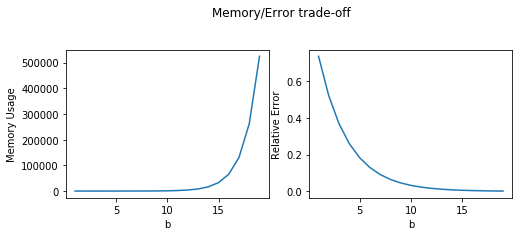

In [26]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plt.plot(range(1,20),[2**i for i in range(1,20)])
plt.xlabel("b")
plt.ylabel("Memory Usage")
plt.subplot(2, 2, 2)
plt.plot(range(1,20),[1.04/np.sqrt(2**i) for i in range(1,20)])
plt.xlabel("b")
plt.ylabel("Relative Error")
plt.suptitle("Memory/Error trade-off")
plt.show()

#### CountMin

For the CountMin sketch one can choose two parameters, $\delta$ and $\epsilon$. These control the precision of the sketch. The smaller one makes $\delta$ and $\epsilon$, the closer to an explicit representation of $M$ one gets to, thus using more memory. $1-\delta$ is the prbability that the estimate is within $\epsilon$ factors from the true count. Through trial and error we landed at satisfactory values for the parameters at $\delta$ = 0.001 and $\epsilon$ = 0.00001 . Lower values of $\epsilon$ did provide even better results, but because the memory/error trade off the currrent value was deemed sufficient.

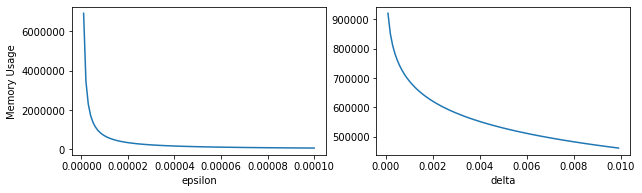

In [28]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(np.arange(0.000001,0.0001,0.000001),[(1/i *(np.log(1/0.001))) for i in np.arange(0.000001,0.0001,0.000001)])
plt.xlabel("epsilon")
plt.ylabel("Memory Usage")
plt.subplot(2, 2, 2)
plt.plot(np.arange(0.0001,0.01,0.0001),[(1/0.00001 *(np.log(1/i))) for i in np.arange(0.0001,0.01,0.0001)])
plt.xlabel("delta")
plt.show()